In [1]:
import pandas as pd
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
import rdkit.DataStructs as DataStructs

import numpy as np

In this notebook the compounds in the data set are analyzed based on structural similarity. The similarity is calculated using the Morgan fingerprint and the Tanimoto similarity metric to see whether or not there is a lot of structural variance within and between classes or not. 

In [2]:
#Loading the data
data = pd.read_csv("Data_set/Train/train.csv")
data2 = pd.read_csv("Data_set/Test/test.csv")
data.set_index("CID", inplace=True)
data2.set_index("CID", inplace=True)
data = pd.concat([data, data2])

#Creating the molecule object and the fingerprint
data['mol'] = data['IsomericSMILES'].apply(Chem.MolFromSmiles)
data['fp'] = data['mol'].apply(AllChem.GetMorganFingerprintAsBitVect, args=(2, 2024))

print(data)

,IsomericSMILES,Descriptors,MolecularWeight,Descriptor Count,alcohol,animal,aquatic,earthy,flower,fruity,green,herbal,savory,spices,woody,mol,fp
CID,,,,,,,,,,,,,,,,,
49,CC(C)C(=O)C(=O)O,['fruity'],116.047344,1,0,0,0,0,0,1,0,0,0,0,0,<rdkit.Chem.rdchem.Mol object at 0x0000026B900...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
70,CC(C)CC(=O)C(=O)O,['fruity'],130.062994,1,0,0,0,0,0,1,0,0,0,0,0,<rdkit.Chem.rdchem.Mol object at 0x0000026B900...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
98,C(C(=O)C(=O)O)S,['savory'],119.988115,1,0,0,0,0,0,0,0,0,1,0,0,<rdkit.Chem.rdchem.Mol object at 0x0000026B900...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
107,C1=CC=C(C=C1)CCC(=O)O,"['savory', 'spices', 'flower', 'animal']",150.068080,4,0,1,0,0,1,0,0,0,1,1,0,<rdkit.Chem.rdchem.Mol object at 0x0000026B900...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
119,C(CC(=O)O)CN,['savory'],103.063329,1,0,0,0,0,0,0,0,0,1,0,0,<rdkit.Chem.rdchem.Mol object at 0x0000026B900...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151532504,CC(=CCCC(CCO)C=C)C,['flower'],168.151415,1,0,0,0,0,1,0,0,0,0,0,0,<rdkit.Chem.rdchem.Mol object at 0x0000026B930...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
153900859,CC(C)C1=CC(=C(C=C1)CC=O)C(C)C,['animal'],204.151415,1,0,1,0,0,0,0,0,0,0,0,0,<rdkit.Chem.rdchem.Mol object at 0x0000026B930...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
154236401,CCCCOC(=S)C(C)C,"['savory', 'fruity', 'green']",160.092186,3,0,0,0,0,0,1,1,0,1,0,0,<rdkit.Chem.rdchem.Mol object at 0x0000026B930...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [3]:
#Getting all compounds in a dictionary divided by class.
classes = {'alcohol': data[data["alcohol"] == 1],
'animal': data[data["animal"] == 1],
'aquatic': data[data["aquatic"] == 1],
'earthy': data[data["earthy"] == 1],
'flower': data[data["flower"] == 1],
'fruity': data[data["fruity"] == 1],
'green': data[data["green"] == 1],
'herbal': data[data["herbal"] == 1],
'spices': data[data["spices"] == 1],
'savory': data[data["savory"] == 1],
'woody': data[data["woody"] == 1]}

print(classes)
print(classes.keys())

{'alcohol':                   IsomericSMILES  \
CID                                
177                         CC=O   
263                        CCCCO   
527                        CCC=O   
701           CCOC(=O)C(C)C(=O)C   
702                          CCO   
...                          ...   
101588415        CCCCCOC(C)OCCCC   
101599349    CCCCCC(OCC)OCCC(C)C   
101834900     CCCCCCOC(CCCCC)OCC   
101834904  CCCCCCOC(CCCC)OCCCCCC   
149252478      CCCCCC1C(=O)OCCO1   

                                                 Descriptors  MolecularWeight  \
CID                                                                             
177        ['animal', 'aquatic', 'alcohol', 'savory', 'fr...        44.026215   
263                          ['savory', 'fruity', 'alcohol']        74.073165   
527        ['fruity', 'aquatic', 'alcohol', 'savory', 'ea...        58.041865   
701                           ['alcohol', 'fruity', 'green']       144.078644   
702                              

In [4]:
from tqdm import tqdm

results = {'alcohol': [],
'animal': [],
'aquatic': [],
'earthy': [],
'flower': [],
'fruity': [],
'green': [],
'herbal': [],
'spices': [],
'savory': [],
'woody': []}

#Calculate the similarity between the compounds in each class using RDkit fingerprint similarity.
for descriptor in classes.keys():
    fps = [data.loc[classes[descriptor].index].iloc[i]['fp'] for i in range(len(classes[descriptor]))]

    #Create a similarity matrix
    similarity_matrix = pd.DataFrame(index=classes[descriptor].index, columns=classes[descriptor].index)
    similarity_matrix = similarity_matrix.fillna(0)

    means = []

    #Populate the similarity matrix
    for i in tqdm(range(len(classes[descriptor]))):
        for j in range(len(classes[descriptor])):
            similarity_matrix.iloc[i, j] = DataStructs.FingerprintSimilarity(fps[i], fps[j])

        row = similarity_matrix.iloc[i, :]
        row = row.drop(row.idxmax())

        mean = row.mean()
        means.append(mean)

    results[descriptor] = means

100%|██████████| 186/186 [00:01<00:00, 103.01it/s]


{'alcohol': [0.08534728365329057,
  0.16126388838595604,
  0.1420585817723077,
  0.2264763838898827,
  0.12637902412050392,
  0.1312438226460499,
  0.05595572654892051,
  0.14070182516950772,
  0.09213901799297157,
  0.17040460028253343,
  0.1069630646680492,
  0.19751286504833657,
  0.12735197613874286,
  0.15022457807154196,
  0.1227534137975044,
  0.18845893614126447,
  0.23767109224417385,
  0.1542916103352099,
  0.014884854616502963,
  0.16999073475318488,
  0.09751448527302584,
  0.2384491780787805,
  0.20574574927799755,
  0.24315239387455215,
  0.12466124988217228,
  0.048907550078812714,
  0.1632925088446168,
  0.20627339717635215,
  0.17680847804450903,
  0.14984594221853562,
  0.24542892698737456,
  0.18590397871119682,
  0.18065409437061378,
  0.3042970662292675,
  0.29989486908954105,
  0.3170633380927917,
  0.3170633380927917,
  0.11179953102231585,
  0.2057460529970574,
  0.11471143143891982,
  0.13565845987458103,
  0.25267913549208737,
  0.11448472429806225,
  0.042348

In [5]:
#Get the mean, std, min, max, median, 25% and 75% of the similarity values for each class.
sims = pd.DataFrame(columns=[ 'mean', 'std', 'min', 'max', 'median', '25%', '75%'], index=classes.keys())

for descriptor in classes.keys():
    sims.loc[descriptor]['mean'] = np.mean(results[descriptor])
    sims.loc[descriptor]['std'] = np.std(results[descriptor])
    sims.loc[descriptor]['min'] = np.min(results[descriptor])
    sims.loc[descriptor]['max'] = np.max(results[descriptor])
    sims.loc[descriptor]['median'] = np.median(results[descriptor])
    sims.loc[descriptor]['25%'] = np.percentile(results[descriptor], 25)
    sims.loc[descriptor]['75%'] = np.percentile(results[descriptor], 75)

sims


,mean,std,min,max,median,25%,75%
alcohol,0.205631,0.069848,0.014885,0.330975,0.208921,0.157146,0.252841
animal,0.097832,0.021103,0.024662,0.151287,0.09727,0.08508,0.112826
aquatic,0.119247,0.035255,0.002717,0.191991,0.121109,0.095912,0.14554
earthy,0.101735,0.024086,0.029216,0.16415,0.101458,0.084422,0.116396
flower,0.130423,0.032542,0.013121,0.205583,0.129486,0.109311,0.154431
fruity,0.141911,0.041654,0.012246,0.222712,0.143188,0.113063,0.17144
green,0.125577,0.0369,0.003834,0.202473,0.126409,0.097918,0.153796
herbal,0.109756,0.02373,0.00105,0.166626,0.109877,0.092375,0.127641
spices,0.141912,0.035579,0.038889,0.214441,0.145554,0.111656,0.171891
savory,0.105944,0.031243,0.000042,0.169137,0.106885,0.084991,0.128866


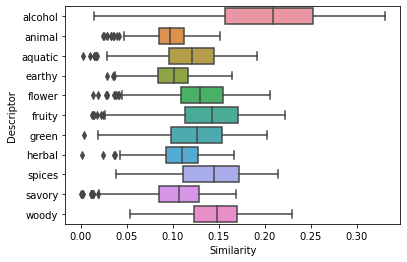

MEAN:  0.1254550750873014
STD:  0.041477962378436754
MIN:  4.2157538505641734e-05
MAX:  0.33097529056771857


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

#Plotting the above created "sims" dataframe.
tidy_data = pd.DataFrame([(k, v) for k, vals in results.items() for v in vals], columns=['Box', 'Value'])

sns.boxplot(x=tidy_data['Value'], y=tidy_data['Box'], orient='h')

# Customize plot
plt.xlabel('Similarity')
plt.ylabel('Descriptor')

# Display the plot
plt.savefig('../images/within_class_sim.png', dpi=300, bbox_inches='tight')
plt.show()

print("MEAN: ", tidy_data['Value'].mean())
print("STD: ", tidy_data['Value'].std())
print("MIN: ", tidy_data['Value'].min())
print("MAX: ", tidy_data['Value'].max())

In [38]:
#Here we are calculating the average similarity between classes.

descriptors = list(classes.keys())

results = {}

for descriptor in tqdm(descriptors, desc="Outer loop", leave=True):
    fps1 = [data.loc[classes[descriptor].index].iloc[i]['fp'] for i in range(len(classes[descriptor]))]

    descriptors2 = descriptors.copy()
    descriptors2.remove(descriptor)

    for descriptor2 in descriptors2:
        fp2 = [data.loc[classes[descriptor2].index].iloc[i]['fp'] for i in range(len(classes[descriptor2]))]

        #Create a similarity matrix
        similarity_matrix = pd.DataFrame(index=classes[descriptor].index, columns=classes[descriptor2].index)
        similarity_matrix = similarity_matrix.fillna(0)

        means = []

        #Populate the similarity matrix
        for i in tqdm(range(len(classes[descriptor])), desc="Inner loop", leave=False):
            for j in range(len(classes[descriptor2])):
                similarity_matrix.iloc[i, j] = DataStructs.FingerprintSimilarity(fps1[i], fp2[j])

            row = similarity_matrix.iloc[i, :]
            row = row.drop(row.idxmax())

            mean = row.mean()
            means.append(mean)

        results[descriptor, descriptor2] = means

Outer loop: 100%|██████████| 11/11 [4:38:01<00:00, 1516.46s/it] 


In [39]:
list(results.keys())

[('alcohol', 'animal'),
 ('alcohol', 'aquatic'),
 ('alcohol', 'earthy'),
 ('alcohol', 'flower'),
 ('alcohol', 'fruity'),
 ('alcohol', 'green'),
 ('alcohol', 'herbal'),
 ('alcohol', 'spices'),
 ('alcohol', 'savory'),
 ('alcohol', 'woody'),
 ('animal', 'alcohol'),
 ('animal', 'aquatic'),
 ('animal', 'earthy'),
 ('animal', 'flower'),
 ('animal', 'fruity'),
 ('animal', 'green'),
 ('animal', 'herbal'),
 ('animal', 'spices'),
 ('animal', 'savory'),
 ('animal', 'woody'),
 ('aquatic', 'alcohol'),
 ('aquatic', 'animal'),
 ('aquatic', 'earthy'),
 ('aquatic', 'flower'),
 ('aquatic', 'fruity'),
 ('aquatic', 'green'),
 ('aquatic', 'herbal'),
 ('aquatic', 'spices'),
 ('aquatic', 'savory'),
 ('aquatic', 'woody'),
 ('earthy', 'alcohol'),
 ('earthy', 'animal'),
 ('earthy', 'aquatic'),
 ('earthy', 'flower'),
 ('earthy', 'fruity'),
 ('earthy', 'green'),
 ('earthy', 'herbal'),
 ('earthy', 'spices'),
 ('earthy', 'savory'),
 ('earthy', 'woody'),
 ('flower', 'alcohol'),
 ('flower', 'animal'),
 ('flower', 'aq

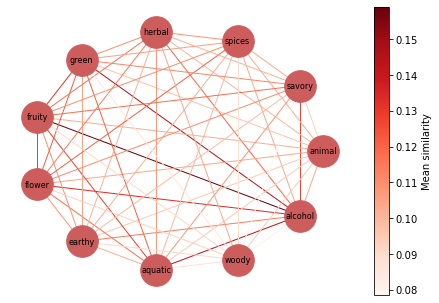

In [44]:
import networkx as nx
import matplotlib.pyplot as plt
import pygraphviz
from networkx.drawing.nx_agraph import graphviz_layout

#Plot the between class similarity as a graph. The edge weight indicates the level of similarity between classes.

descriptors = list(classes.keys())

G = nx.Graph()

#Add nodes
for descriptor in descriptors:
    G.add_node(descriptor)

#Add edges
for key in results.keys():
    #Put weight on a log scale from 0 to 1
    weight = np.mean(results[key])
    
    G.add_edge(key[0], key[1], weight=weight)

edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())

#Draw graph
pos = graphviz_layout(G, prog='circo')
nx.draw(G, pos, with_labels=True, node_color='indianred', edge_color=weights, edge_cmap=plt.cm.Reds,  linewidths=1, font_size=8, node_size=1000)

sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=min(weights), vmax=max(weights)))
sm._A = []

plt.colorbar(sm, label='Mean similarity')
plt.savefig('../images/between_class_sim.png', dpi=300)

In [ ]:
from tqdm import tqdm

#Here we are calculating the similarity between all compounds in the dataset with the same combination of descriptors to see if those compounds are similar to each other.

data['Descriptors'].value_counts().sort_values(ascending=False)

#Select all rows where the column "Descriptors" appears more than once in the entire dataset
combos = data[data['Descriptors'].isin(data['Descriptors'].value_counts()[data['Descriptors'].value_counts() > 1].index)]

results = {}

for descriptor in tqdm(combos['Descriptors'].unique()):
    #Get all rows where the column "Descriptors" is equal to the current descriptor

    fps = combos[combos['Descriptors'] == descriptor]['fp'].tolist()

    #Create a similarity matrix
    similarity_matrix = pd.DataFrame(combos[combos['Descriptors'] == descriptor].index, columns=combos[combos['Descriptors'] == descriptor].index, index=combos[combos['Descriptors'] == descriptor].index)
    similarity_matrix = similarity_matrix.fillna(0)

    means = []

    #Populate the similarity matrix
    for i in tqdm(range(len(combos[combos['Descriptors'] == descriptor]))):
        for j in range(len(combos[combos['Descriptors'] == descriptor])):
            similarity_matrix.iloc[i, j] = DataStructs.FingerprintSimilarity(fps[i], fps[j])

        row = similarity_matrix.iloc[i, :]
        row = row.drop(row.idxmax())

        mean = row.mean()
        means.append(mean)

    results[descriptor] = means

results

100%|██████████| 295/295 [01:03<00:00,  4.62it/s]


{"['fruity']": [0.12734134550703002,
  0.14607012240988101,
  0.05416807740815085,
  0.16257043628974233,
  0.15848763672914815,
  0.16855271835763136,
  0.11127521828774317,
  0.11741109497455998,
  0.17328945811722302,
  0.052825262052370724,
  0.19929803235528384,
  0.0643912282885802,
  0.07090514937472008,
  0.05672357074943087,
  0.056603584521659936,
  0.06377291277311006,
  0.028877845697801316,
  0.21495453099715506,
  0.09628510299649863,
  0.19700303602648725,
  0.013539434868165287,
  0.06523446350000615,
  0.1464036069446014,
  0.11760709737042202,
  0.09321323148533643,
  0.08227107985961998,
  0.17523183077876972,
  0.2013317378259485,
  0.12368915797238524,
  0.1926827477082478,
  0.2309611360335525,
  0.22390936937939332,
  0.14620713876474856,
  0.15900136659016317,
  0.12784324765601401,
  0.16157755008214655,
  0.15360175585626923,
  0.04754766239886766,
  0.15316904701771522,
  0.15595959458883035,
  0.1531383504254768,
  0.17705426146408354,
  0.15113309156481147,

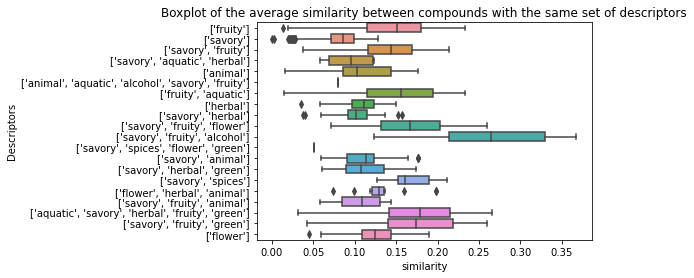

MEAN:  0.12154769804712942
STD:  0.047263513384518126
MIN:  7.522756337922214e-05
MAX:  0.3676068706842925


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

tidy_data = pd.DataFrame([(k, v) for k, vals in list(results.items())[:20] for v in vals], columns=['Box', 'Value'])

sns.boxplot(x=tidy_data['Value'], y=tidy_data['Box'], orient='h')

# Customize plot
plt.xlabel('similarity')
plt.ylabel('Descriptors')
plt.title('Boxplot of the average similarity between compounds with the same set of descriptors')

# Display the plot
plt.show()

print("MEAN: ", tidy_data['Value'].mean())
print("STD: ", tidy_data['Value'].std())
print("MIN: ", tidy_data['Value'].min())
print("MAX: ", tidy_data['Value'].max())

100%|██████████| 11/11 [00:00<00:00, 73.83it/s]


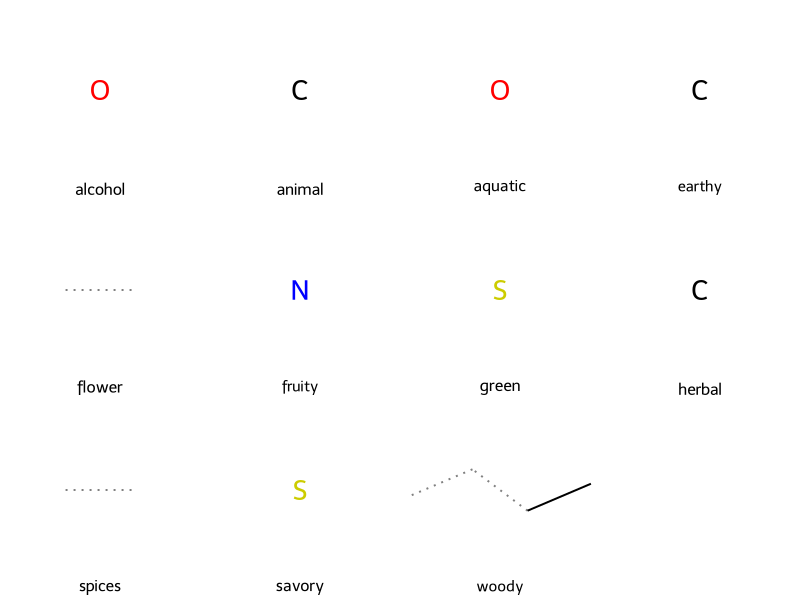

In [ ]:
from rdkit.Chem import rdFMCS
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

#Plot the most common substructure for each class.
structures = []

for descriptor in tqdm(classes.keys()):
    mols = classes[descriptor]['mol'].tolist()

    mcs = rdFMCS.FindMCS(mols)

    structure = Chem.MolFromSmarts(mcs.smartsString)

    structures.append(structure)

Draw.MolsToGridImage(structures, molsPerRow=4, subImgSize=(200, 200), legends=list(classes.keys()))

100%|██████████| 295/295 [00:12<00:00, 23.14it/s]
c:\Users\Stijn\anaconda3\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


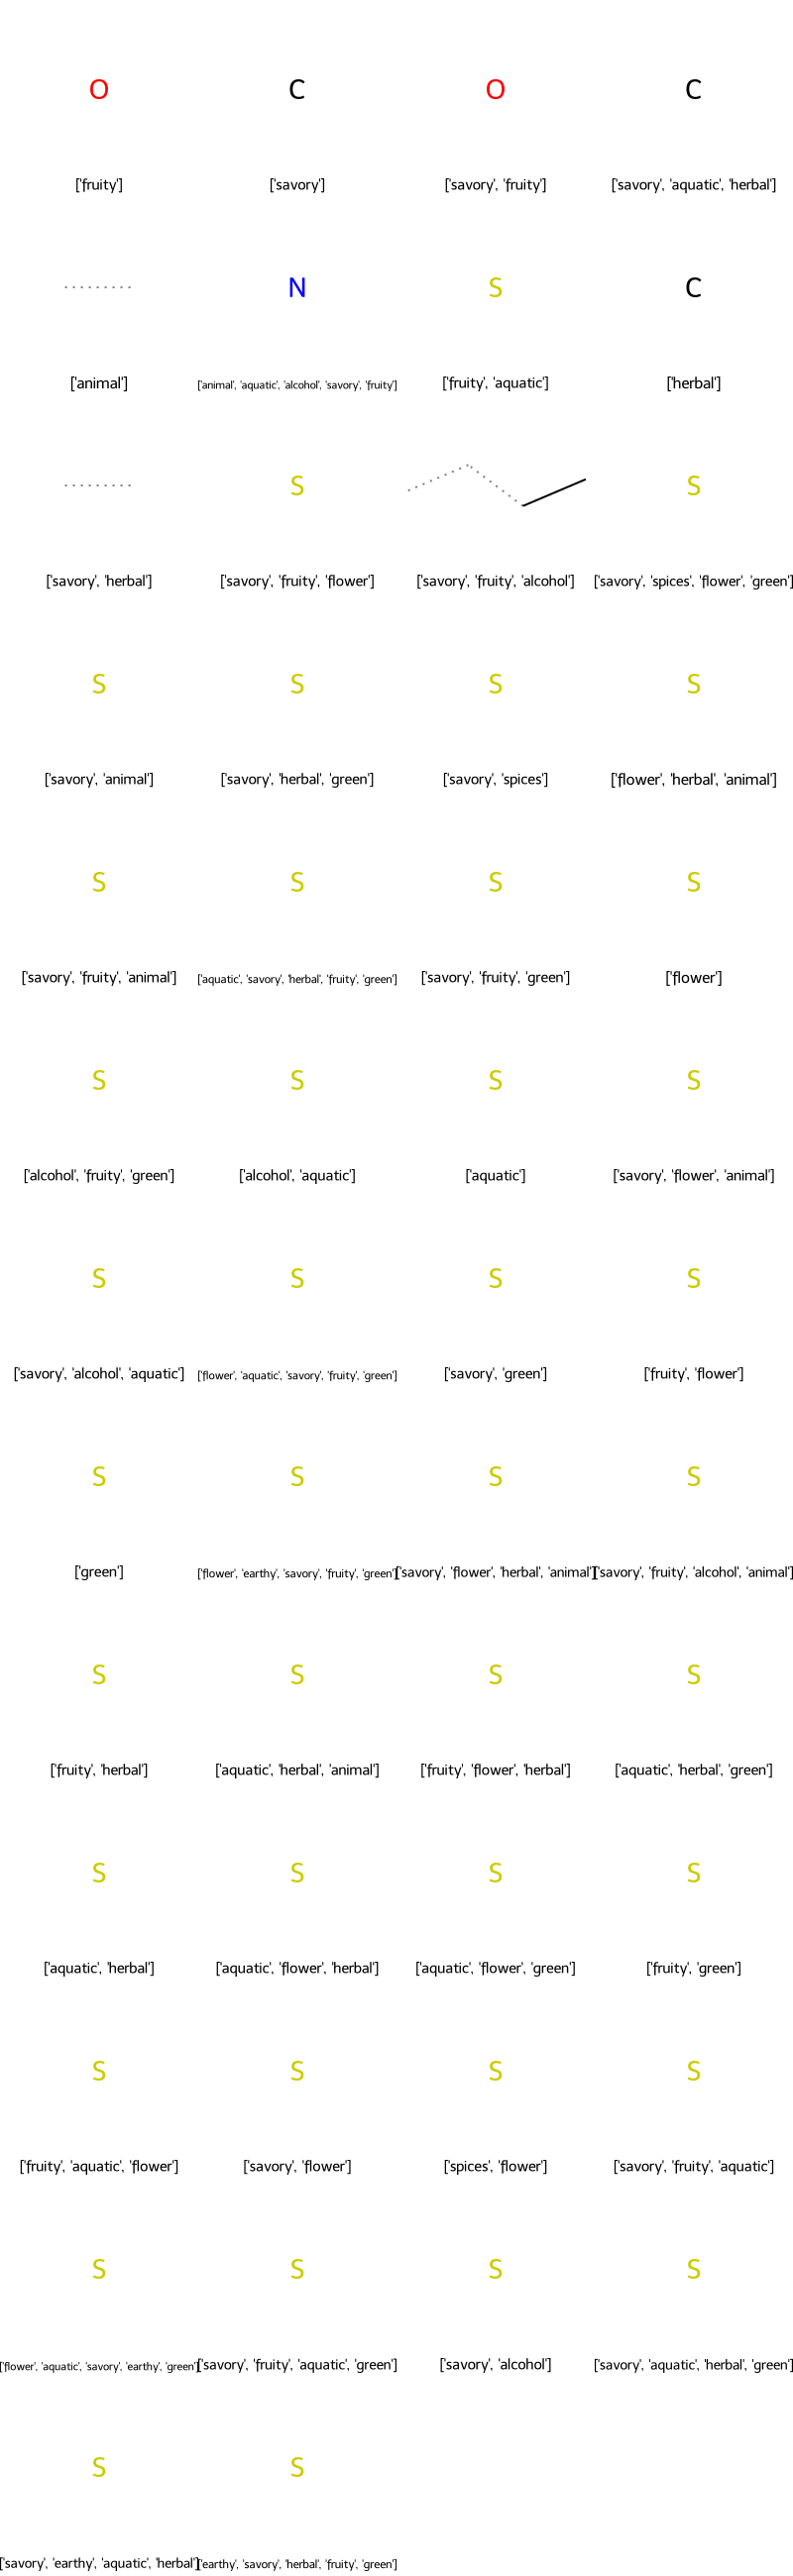

In [ ]:
#Plot the most common substructure for each unique combination of descriptors.
for descriptor in tqdm(combos['Descriptors'].unique()):
    mols = data.loc[combos.index]['mol'].tolist()

    mcs = rdFMCS.FindMCS(mols)

    structure = Chem.MolFromSmarts(mcs.smartsString)

    structures.append(structure)

Draw.MolsToGridImage(structures, molsPerRow=4, subImgSize=(200, 200), legends=combos['Descriptors'].unique().tolist())